# How to setup up LSTM in Tensorflow

The theoretical steps for understanding how an LSTM model works can be challenging, but the tools available in Tensorflow help with setting up an LSTM. I found the notation for and pre-processing of the X_train and Y_train matrix to be a little tricky, thus I thought that I would outline the steps in a short blog post.

LSTM is an interesting algorithm for predicting the next point in a time-series, or whether the next point or group of points in a time-series are associated with a certain class. For example, in financial forecasting where predicting the next point or several points are important, one might want to use LSTM using return_sequence set to True for a specific observation window. Or for domains like psychology, neuroscience, and human activity where data is collected over a period of time often called a trial such that behavior can be predicted per trial, one might want to use LSTM using return_sequence set to False for a specific observation window.

<img src="splash.png" style="width:150;height:250px;">
<caption><center><font color='purple'><b>Figure 1</b>: LSTM </center></caption>
    
Created by Jamilah Foucher

## Load data

I used the same dataset that was used in a Tensorflow tutorial located at : https://www.tensorflow.org/tutorials/structured_data/time_series#setup.

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2022-06-04 17:34:36.710259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 17:34:36.710391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path)

# In the Tensorflow tutorial they start with data from the 5th row, and then take 
# a sample every 6 rows.
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# Load subfunctions

In [16]:
def unsupervised_lab_kmeans_clustering(*arg):
    
    n_clusters = arg[0]
    X = arg[1]
    
    X = np.array(X)
    
    if len(X.shape) == 1 or X.shape[1] == 1:
        X = np.ravel(X)
        out = pd.Series(X)
        X = pd.concat([out, out], axis=1).to_numpy()
    
    from sklearn import cluster
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',algorithm='elkan', random_state=2)
    
    # ------------------------------
    
    # print('shape of X : ', X.shape)
    kmeans.fit(X)

    # ------------------------------

    # Get the prediction of each category : predicted label
    label = kmeans.labels_
    # print('clusters_out : ' + str(clusters_out))
    # OR
    label = kmeans.predict(X)
    # print('clusters_out : ' + str(clusters_out))
    # print('length of clusters_out', len(clusters_out))
    
    # ------------------------------
    
    # Centroid values for feature space : this is the center cluster value per feature in X
    centroids = kmeans.cluster_centers_
    # print('centroids org : ' + str(centroids))

    # ------------------------------
    
    return kmeans, label, centroids

In [17]:
def create_X_batch_timesteps_feature(X, y_bin, input_width, return_sequences):
    
    g = np.argmax(y_bin, axis=1)
    n_outputs = len(np.unique(g))
    print('n_outputs:' , n_outputs)
    
    batch = int(np.floor(X.shape[0]/input_width))

    Xout = []
    yout = []
    for i in range(batch):
        st = i*input_width
        endd = st + input_width
        Xout.append(X[st:endd,:])
        yout.append(y_bin[st:endd,:])

    Xout = np.array(Xout)
    yout = np.array(yout)

    batch, timesteps, feature = Xout.shape
    print('batch:' , batch)
    print('timesteps:' , timesteps)
    print('feature:' , feature)

    # if return_sequences == True:
        # yout : (batch, timesteps, n_outputs)

    if return_sequences == False:
        # yout : (batch, 1, n_outputs)
        yt = [yout[i,0:1,:] for i in range(batch)]
        yout = np.array(yt)
        yout = np.reshape(yout, (batch, n_outputs))
        
    print('Xout:' , Xout.shape)
    print('yout:' , yout.shape)  
        
    tf_data = tf.data.Dataset.from_tensor_slices((Xout, yout))
    tf_data = tf_data.batch(batch)

    return tf_data, Xout, yout, n_outputs

In [18]:
def binarize_Y1Dvec_2_Ybin(Y):
    
    import numpy as np
    
    # Transform a 1D Y vector (n_samples by 1) to a Y_bin (n_samples by n_classes) vector

    # Ensure vector is of integers
    Y = [int(i) for i in Y]

    # Number of samples
    m_examples = len(Y)

    # Number of classes
    temp = np.unique(Y)
    unique_classes = [int(i) for i in temp]
    # print('unique_classes : ', unique_classes)

    whichone = 2
    # Binarize the output
    if whichone == 0:
        from sklearn.preprocessing import label_binarize
        Y_bin = label_binarize(Y, classes=unique_classes)  # does not work

    elif whichone == 1:
        from sklearn import preprocessing
        lb = preprocessing.LabelBinarizer()
        Y_bin = lb.fit_transform(Y)
        
    elif whichone == 2:
        # By hand
        Y_bin = np.zeros((m_examples, len(unique_classes)))
        for i in range(0, m_examples):
            if Y[i] == unique_classes[0]:
                Y_bin[i,0] = 1
            elif Y[i] == unique_classes[1]:
                Y_bin[i,1] = 1
            elif Y[i] == unique_classes[2]:
                Y_bin[i,2] = 1
            elif Y[i] == unique_classes[3]:
                Y_bin[i,3] = 1
            elif Y[i] == unique_classes[4]:
                Y_bin[i,4] = 1
            elif Y[i] == unique_classes[5]:
                Y_bin[i,5] = 1
            elif Y[i] == unique_classes[6]:
                Y_bin[i,6] = 1
                
    print('shape of Y_bin : ', Y_bin.shape)

    return Y_bin, unique_classes

In [19]:
def LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, n_outputs):

    model = Sequential()
    
    model.add(LSTM(n_a, input_shape=(timesteps_train, feature), 
                   return_sequences=return_sequences, return_state=return_state))

    # Types of W initializer :
    initializer = tf.keras.initializers.HeUniform()

    if n_outputs == 2:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))

    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    # opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

    # Si vous utilisez softmax activation, la taille de sortie est plus grand que deux donc il faut categorical_crossentropy
    if n_outputs == 2:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'

    # model.summary()

    return model

## Forecasting example 

Here we obtain an output for each timestep for each batch using the function input return_sequences = True. Below we first assign the X and y matrices, create a y label from the temperature column in the DataFrame (T (degC)). Using kmeans we can create a y label with 2 or more classes. In the figure, we can see that perhaps 3 classes captures the fluctuations in the temperature data so let us choose 3 classes for the examples.

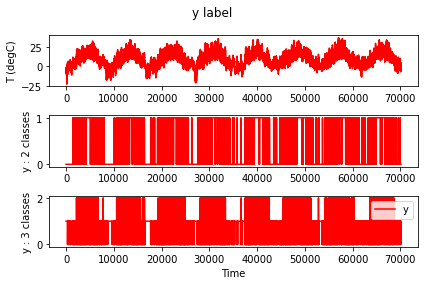

In [25]:
X = df.to_numpy()
yorg = df.iloc[:,1:2].to_numpy()

# ---------------------

# Create binary y label
n_clusters = 2
kmeans, y_class2, centroids = unsupervised_lab_kmeans_clustering(n_clusters, yorg)
n_clusters = 3
kmeans, y_class3, centroids = unsupervised_lab_kmeans_clustering(n_clusters, yorg)


import matplotlib.pyplot as plt 
fig, (ax0, ax1, ax2) = plt.subplots(3)

fig.suptitle('y label')
ax0.plot(yorg, 'r', label='y')
ax0.set_ylabel('T (degC)')

ax1.plot(y_class2, 'r', label='y')
ax1.set_ylabel('y : 2 classes')

ax2.plot(y_class3, 'r', label='y')
ax2.set_ylabel('y : 3 classes')
ax2.set_xlabel('Time')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [26]:
# ---------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_class3, 
                                                    train_size=0.8, 
                                                    test_size=0.2, random_state=0)

# ---------------------

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

print('X_train_scaled:' , X_train_scaled.shape)
print('X_test_scaled:' , X_test_scaled.shape)
print('y_train:' , y_train.shape)
print('y_test:' , y_test.shape)

# ---------------------

Y_bin_train, unique_classes = binarize_Y1Dvec_2_Ybin(y_train)
Y_bin_test, unique_classes = binarize_Y1Dvec_2_Ybin(y_test)

# ---------------------

X_train_scaled: (56072, 14)
X_test_scaled: (14019, 14)
y_train: (56072,)
y_test: (14019,)
shape of Y_bin :  (56072, 3)
shape of Y_bin :  (14019, 3)


In [27]:
# Initialize
n_a = 32
return_sequences = True

input_width = 24 # It seems like 24 was choosen because perhaps a weather sample was choosen 
# every hour in a span of one day. So we want to look at timestep samples per day.

tf_train, X_train2, y_train2, n_outputs = create_X_batch_timesteps_feature(X_train_scaled, Y_bin_train, input_width, return_sequences)
tf_test, X_test2, y_test2, n_outputs = create_X_batch_timesteps_feature(X_test_scaled, Y_bin_test, input_width, return_sequences)

timesteps_train = X_train2.shape[1]
feature = X_train2.shape[2]

return_state = False # must use functional format to have a and c matricies returned

# ---------------------

n_outputs: 3
batch: 2336
timesteps: 24
feature: 14
Xout: (2336, 24, 14)
yout: (2336, 24, 3)
n_outputs: 3
batch: 584
timesteps: 24
feature: 14
Xout: (584, 24, 14)
yout: (584, 24, 3)


In [28]:
# Run model
model = LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, n_outputs)

MAX_EPOCHS = 100
patience = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
history = model.fit(tf_train, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=2)

# ---------------------

Epoch 1/100
1/1 - 3s - loss: 1.1588 - accuracy: 0.2442 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3304 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 1.1489 - accuracy: 0.2811 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3578 - 151ms/epoch - 151ms/step
Epoch 3/100
1/1 - 0s - loss: 1.1392 - accuracy: 0.3086 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3870 - 130ms/epoch - 130ms/step
Epoch 4/100
1/1 - 0s - loss: 1.1297 - accuracy: 0.3301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4175 - 132ms/epoch - 132ms/step
Epoch 5/100
1/1 - 0s - loss: 1.1205 - accuracy: 0.3474 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4490 - 131ms/epoch - 131ms/step
Epoch 6/100
1/1 - 0s - loss: 1.1114 - accuracy: 0.3624 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4815 - 132ms/epoch - 132ms/step
Epoch 7/100
1/1 - 0s - loss: 1.1026 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5143 - 133ms/epoch - 133ms/step
Epoch 8/100
1/1 - 0

Epoch 62/100
1/1 - 0s - loss: 0.6470 - accuracy: 0.8128 - precision: 0.8972 - recall: 0.6201 - auc: 0.9469 - 200ms/epoch - 200ms/step
Epoch 63/100
1/1 - 0s - loss: 0.6379 - accuracy: 0.8178 - precision: 0.8989 - recall: 0.6330 - auc: 0.9494 - 150ms/epoch - 150ms/step
Epoch 64/100
1/1 - 0s - loss: 0.6288 - accuracy: 0.8227 - precision: 0.9003 - recall: 0.6462 - auc: 0.9518 - 229ms/epoch - 229ms/step
Epoch 65/100
1/1 - 0s - loss: 0.6197 - accuracy: 0.8269 - precision: 0.9019 - recall: 0.6586 - auc: 0.9541 - 139ms/epoch - 139ms/step
Epoch 66/100
1/1 - 0s - loss: 0.6107 - accuracy: 0.8317 - precision: 0.9037 - recall: 0.6706 - auc: 0.9564 - 128ms/epoch - 128ms/step
Epoch 67/100
1/1 - 0s - loss: 0.6018 - accuracy: 0.8361 - precision: 0.9053 - recall: 0.6812 - auc: 0.9585 - 130ms/epoch - 130ms/step
Epoch 68/100
1/1 - 0s - loss: 0.5930 - accuracy: 0.8402 - precision: 0.9073 - recall: 0.6924 - auc: 0.9606 - 127ms/epoch - 127ms/step
Epoch 69/100
1/1 - 0s - loss: 0.5842 - accuracy: 0.8442 - prec

Minimum validation loss: 0.37726083397865295


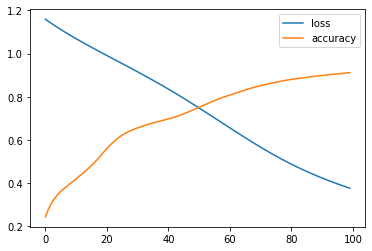

In [33]:
# Plotting the loss function, and validation data
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['loss'].min()))

# Test the model

In [29]:
score = model.evaluate(tf_test, verbose=2)
y_hat = model.predict(X_test2, verbose=2)
y_hat.shape

1/1 - 1s - loss: 0.3736 - accuracy: 0.9155 - precision: 0.9375 - recall: 0.8804 - auc: 0.9886 - 754ms/epoch - 754ms/step
19/19 - 0s - 491ms/epoch - 26ms/step


(584, 24, 3)

### Plot some of the predictions

In [30]:
# Transform probablity of each class to one class number
yout = []
for i in range(y_hat.shape[0]):
    haut_class = [np.argmax(y_hat[i,j,:]) for j in range(y_hat.shape[1])]
    yout.append(haut_class)
yout = np.array(yout)

y_test3 = [np.argmax(y_test2[i], axis=1) for i in range(y_test2.shape[0])]
y_test3 = np.array(y_test3)

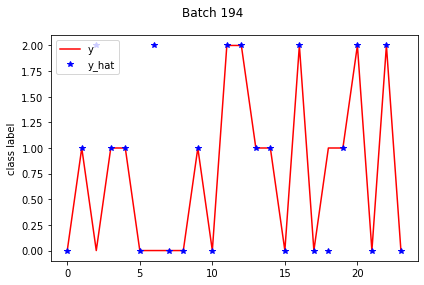

In [32]:
import matplotlib.pyplot as plt 
fig, (ax0) = plt.subplots(1)

b = np.random.permutation(y_test2.shape[0])[0]
fig.suptitle('Batch %s' % (b))
ax0.plot(y_test3[b,:], 'r', label='y')
ax0.plot(yout[b,:], 'b*', label='y_hat')
ax0.set_ylabel('class label')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Output across timesteps for each batch : return_sequences = False 

### test for 3 class or more

In [34]:
X = df.to_numpy()
y = df.iloc[:,1:2].to_numpy()

# ---------------------

# Create binary y label
n_clusters = 3  ## ************* On change ICI *************
kmeans, y, centroids = unsupervised_lab_kmeans_clustering(n_clusters, y)

# ---------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# ---------------------

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

print('X_train_scaled:' , X_train_scaled.shape)
print('X_test_scaled:' , X_test_scaled.shape)
print('y_train:' , y_train.shape)
print('y_test:' , y_test.shape)

# ---------------------

Y_bin_train, unique_classes = binarize_Y1Dvec_2_Ybin(y_train)
Y_bin_test, unique_classes = binarize_Y1Dvec_2_Ybin(y_test)

X_train_scaled: (56072, 14)
X_test_scaled: (14019, 14)
y_train: (56072,)
y_test: (14019,)
shape of Y_bin :  (56072, 3)
shape of Y_bin :  (14019, 3)


In [35]:
# Initialize
n_a = 32
return_sequences = False ## ************* On change ICI *************

input_width = 24 # It seems like 24 was choosen because perhaps a weather sample was choosen 
# every hour in a span of one day. So we want to look at timestep samples per day.

tf_train, X_train2, y_train2, n_outputs = create_X_batch_timesteps_feature(X_train_scaled, Y_bin_train, input_width, return_sequences)
tf_test, X_test2, y_test2, n_outputs = create_X_batch_timesteps_feature(X_test_scaled, Y_bin_test, input_width, return_sequences)

timesteps_train = X_train2.shape[1]
feature = X_train2.shape[2]

return_state = False # must use functional format to have a and c matricies returned
# ---------------------

n_outputs: 3
batch: 2336
timesteps: 24
feature: 14
Xout: (2336, 24, 14)
yout: (2336, 3)
n_outputs: 3
batch: 584
timesteps: 24
feature: 14
Xout: (584, 24, 14)
yout: (584, 3)


In [37]:
# Run model
model = LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, n_outputs)

MAX_EPOCHS = 200
patience = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
history = model.fit(tf_train, epochs=MAX_EPOCHS, callbacks=[early_stopping], verbose=2)

Epoch 1/200
1/1 - 3s - loss: 1.0984 - accuracy: 0.3583 - precision_2: 1.0000 - recall_2: 8.5616e-04 - auc_2: 0.5280 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.0957 - accuracy: 0.3694 - precision_2: 1.0000 - recall_2: 0.0013 - auc_2: 0.5357 - 170ms/epoch - 170ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0932 - accuracy: 0.3724 - precision_2: 1.0000 - recall_2: 0.0013 - auc_2: 0.5432 - 137ms/epoch - 137ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0911 - accuracy: 0.3780 - precision_2: 1.0000 - recall_2: 0.0026 - auc_2: 0.5498 - 171ms/epoch - 171ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0892 - accuracy: 0.3870 - precision_2: 1.0000 - recall_2: 0.0026 - auc_2: 0.5551 - 178ms/epoch - 178ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0876 - accuracy: 0.3998 - precision_2: 0.8000 - recall_2: 0.0034 - auc_2: 0.5596 - 148ms/epoch - 148ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0863 - accuracy: 0.4015 - precision_2: 0.6923 - recall_2: 0.0039 - auc_2: 0.5634 - 126ms/epoch - 126ms/step
Epoch 8/200
1/1 - 0s - loss: 

Epoch 60/200
1/1 - 0s - loss: 0.9740 - accuracy: 0.4880 - precision_2: 0.5565 - recall_2: 0.1622 - auc_2: 0.7010 - 121ms/epoch - 121ms/step
Epoch 61/200
1/1 - 0s - loss: 0.9651 - accuracy: 0.4940 - precision_2: 0.5691 - recall_2: 0.1764 - auc_2: 0.7073 - 135ms/epoch - 135ms/step
Epoch 62/200
1/1 - 0s - loss: 0.9554 - accuracy: 0.5017 - precision_2: 0.5760 - recall_2: 0.1866 - auc_2: 0.7135 - 139ms/epoch - 139ms/step
Epoch 63/200
1/1 - 0s - loss: 0.9447 - accuracy: 0.5077 - precision_2: 0.5773 - recall_2: 0.1999 - auc_2: 0.7207 - 154ms/epoch - 154ms/step
Epoch 64/200
1/1 - 0s - loss: 0.9330 - accuracy: 0.5184 - precision_2: 0.5908 - recall_2: 0.2188 - auc_2: 0.7282 - 131ms/epoch - 131ms/step
Epoch 65/200
1/1 - 0s - loss: 0.9202 - accuracy: 0.5235 - precision_2: 0.5929 - recall_2: 0.2432 - auc_2: 0.7359 - 139ms/epoch - 139ms/step
Epoch 66/200
1/1 - 0s - loss: 0.9078 - accuracy: 0.5257 - precision_2: 0.5973 - recall_2: 0.2654 - auc_2: 0.7421 - 119ms/epoch - 119ms/step
Epoch 67/200
1/1 - 0

Epoch 119/200
1/1 - 0s - loss: 0.6202 - accuracy: 0.6854 - precision_2: 0.6880 - recall_2: 0.6729 - auc_2: 0.8717 - 130ms/epoch - 130ms/step
Epoch 120/200
1/1 - 0s - loss: 0.6181 - accuracy: 0.6845 - precision_2: 0.6876 - recall_2: 0.6717 - auc_2: 0.8726 - 126ms/epoch - 126ms/step
Epoch 121/200
1/1 - 0s - loss: 0.6157 - accuracy: 0.6802 - precision_2: 0.6851 - recall_2: 0.6687 - auc_2: 0.8731 - 142ms/epoch - 142ms/step
Epoch 122/200
1/1 - 0s - loss: 0.6119 - accuracy: 0.6849 - precision_2: 0.6890 - recall_2: 0.6742 - auc_2: 0.8754 - 131ms/epoch - 131ms/step
Epoch 123/200
1/1 - 0s - loss: 0.6088 - accuracy: 0.6926 - precision_2: 0.6948 - recall_2: 0.6832 - auc_2: 0.8770 - 118ms/epoch - 118ms/step
Epoch 124/200
1/1 - 0s - loss: 0.6068 - accuracy: 0.6926 - precision_2: 0.6955 - recall_2: 0.6854 - auc_2: 0.8777 - 209ms/epoch - 209ms/step
Epoch 125/200
1/1 - 0s - loss: 0.6034 - accuracy: 0.6969 - precision_2: 0.6986 - recall_2: 0.6866 - auc_2: 0.8795 - 142ms/epoch - 142ms/step
Epoch 126/200

Epoch 178/200
1/1 - 0s - loss: 0.3551 - accuracy: 0.8545 - precision_2: 0.8550 - recall_2: 0.8532 - auc_2: 0.9639 - 128ms/epoch - 128ms/step
Epoch 179/200
1/1 - 0s - loss: 0.3548 - accuracy: 0.8562 - precision_2: 0.8568 - recall_2: 0.8557 - auc_2: 0.9637 - 145ms/epoch - 145ms/step
Epoch 180/200
1/1 - 0s - loss: 0.3423 - accuracy: 0.8604 - precision_2: 0.8608 - recall_2: 0.8600 - auc_2: 0.9664 - 132ms/epoch - 132ms/step
Epoch 181/200
1/1 - 0s - loss: 0.3466 - accuracy: 0.8622 - precision_2: 0.8630 - recall_2: 0.8600 - auc_2: 0.9652 - 137ms/epoch - 137ms/step
Epoch 182/200
1/1 - 0s - loss: 0.3446 - accuracy: 0.8587 - precision_2: 0.8590 - recall_2: 0.8583 - auc_2: 0.9656 - 129ms/epoch - 129ms/step
Epoch 183/200
1/1 - 0s - loss: 0.3379 - accuracy: 0.8626 - precision_2: 0.8629 - recall_2: 0.8622 - auc_2: 0.9672 - 120ms/epoch - 120ms/step
Epoch 184/200
1/1 - 0s - loss: 0.3377 - accuracy: 0.8647 - precision_2: 0.8658 - recall_2: 0.8647 - auc_2: 0.9668 - 120ms/epoch - 120ms/step
Epoch 185/200

In [38]:
score = model.evaluate(tf_test, verbose=2)
y_hat = model.predict(X_test2, verbose=2)
y_hat.shape

1/1 - 1s - loss: 0.3884 - accuracy: 0.8339 - precision_2: 0.8339 - recall_2: 0.8339 - auc_2: 0.9577 - 901ms/epoch - 901ms/step
19/19 - 0s - 420ms/epoch - 22ms/step


(584, 3)

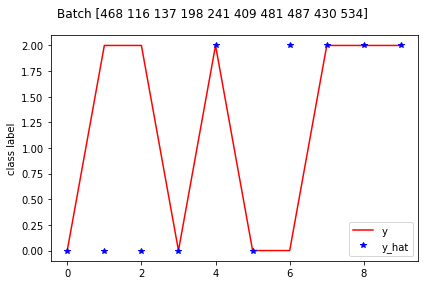

In [40]:
y_hat_1D = np.argmax(y_hat, axis=1)
y_test2_1D = np.argmax(y_test2, axis=1)

import matplotlib.pyplot as plt 
fig, (ax0) = plt.subplots(1)

b = np.random.permutation(len(y_test2_1D))[0:10]
fig.suptitle('Batch %s' % (b))
ax0.plot(y_test2_1D[b], 'r', label='y')
ax0.plot(y_hat_1D[b], 'b*', label='y_hat')
ax0.set_ylabel('class label')
plt.legend(loc='best')
plt.tight_layout()
plt.show()